# MaskRCNN Car Damage Prediction

> Note: This jupyter notebook contains data visualization of car damage images and automated car damage detection example. First we need to import all the packages including custom functions of Matterport Mask R-CNN’ repository 

In [ ]:
import os
import sys
import itertools
import math
import logging
import json
import re
import random
from collections import OrderedDict
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as lines
from matplotlib.patches import Polygon

# Import Mask RCNN
#sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
from mrcnn import model
import mrcnn.model as modellib
from mrcnn.model import log
import cv2
import custom,custom_1
import imgaug,h5py,IPython

%matplotlib inline

Setting up the configuration - root directory,data path setting up the ,log file path and model object(weight matrix)for inference (prediction) 

In [ ]:
# Root directory of the project
ROOT_DIR = os.getcwd()
sys.path.append(ROOT_DIR)  # To find local version of the library
MODEL_DIR = os.path.join(ROOT_DIR, "logs")
custom_WEIGHTS_PATH = "mask_rcnn_scratch_0013.h5"  # TODO: update this path for best performing iteration weights
config = custom.CustomConfig()
custom_DIR = os.path.join(ROOT_DIR, "custom/")
custom_DIR

'C:\\Users\\Sourish\\Mask_RCNN\\custom/'

loading the data

In [ ]:
# Load dataset
dataset = custom_1.CustomDataset()
dataset.load_custom(custom_DIR, "train")

# Must call before using the dataset
dataset.prepare()

print("Image Count: {}".format(len(dataset.image_ids)))
print("Class Count: {}".format(dataset.num_classes))
for i, info in enumerate(dataset.class_info):
    print("{:3}. {:50}".format(i, info['name']))

Image Count: 49
Class Count: 2
  0. BG                                                
  1. scratch                                           


We will visualize few car damage(scratch) images

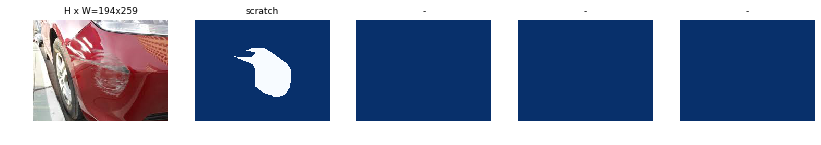

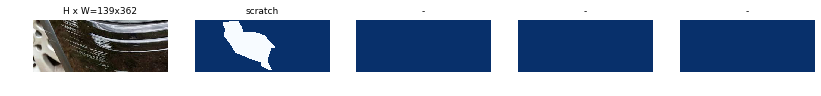

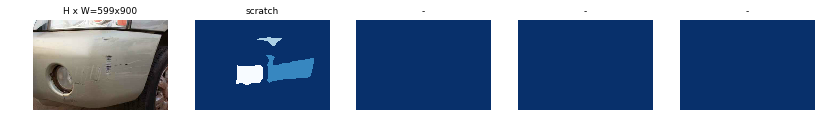

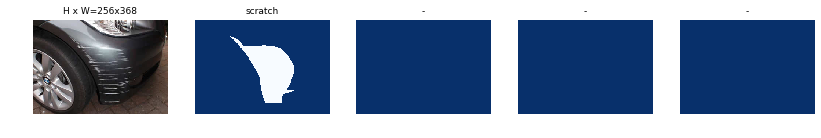

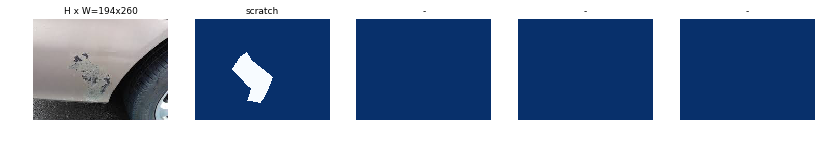

In [ ]:
# Load and display random samples
image_ids = np.random.choice(dataset.image_ids, 5)
for image_id in image_ids:
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names)

Next we will see Bounding Box(BB)with annotated damage mask for a typical car image.

image_id  32 C:\Users\Sourish\Mask_RCNN\custom/train\image35.jpg
image                    shape: (224, 225, 3)         min:    0.00000  max:  255.00000  uint8
mask                     shape: (224, 225, 2)         min:    0.00000  max:    1.00000  bool
class_ids                shape: (2,)                  min:    1.00000  max:    1.00000  int32
bbox                     shape: (2, 4)                min:   81.00000  max:  199.00000  int32


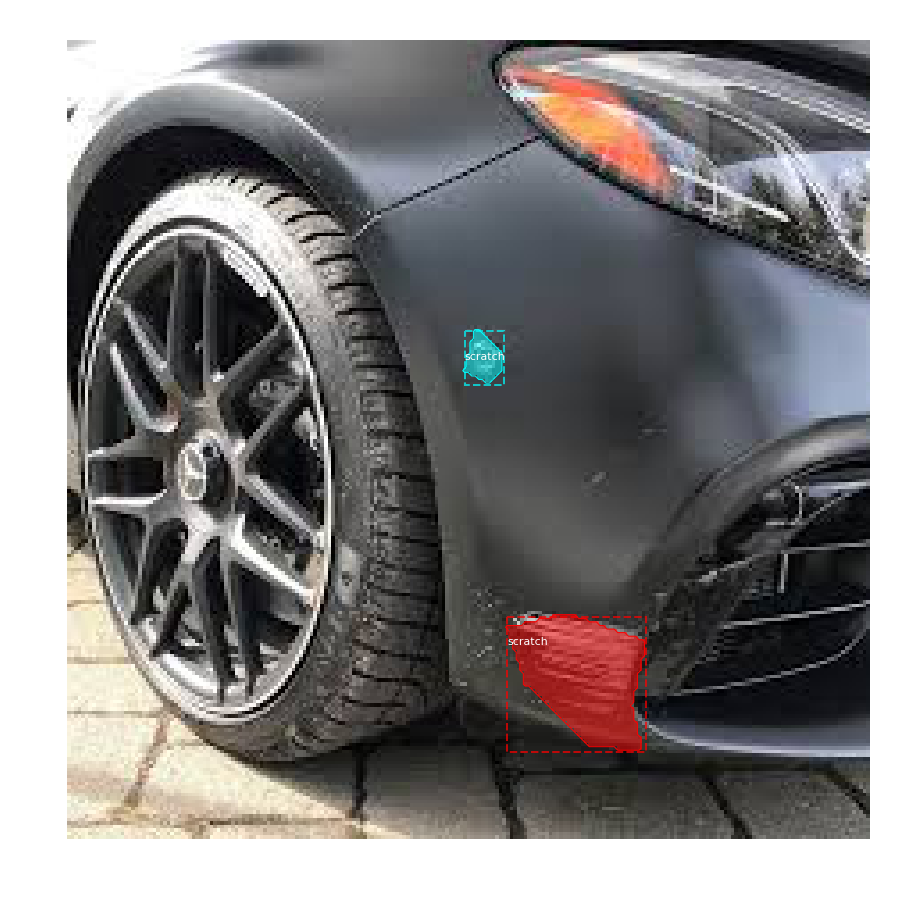

In [ ]:
image_id = random.choice(dataset.image_ids)
image = dataset.load_image(image_id)
mask, class_ids = dataset.load_mask(image_id)
# Compute Bounding box
bbox = utils.extract_bboxes(mask)

# Display image and additional stats
print("image_id ", image_id, dataset.image_reference(image_id))
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)
# Display image and instances
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

We see some the components of image annotations. Mainly it has x and y co-ordinate of all labeled damages('polygon') and class name(here 'scratch') for respective car image.

In [ ]:
#Annotation file load
annotations1 = json.load(open(os.path.join(ROOT_DIR, "via_region_data.json"),encoding="utf8"))
annotations = list(annotations1.values()) 
annotations = [a for a in annotations if a['regions']]
annotations[0]

{'fileref': '',
 'size': 46041,
 'filename': 'image2.jpg',
 'base64_img_data': '',
 'file_attributes': {},
 'regions': {'0': {'shape_attributes': {'name': 'polygon',
    'all_points_x': [428,
     429,
     480,
     518,
     557,
     577,
     610,
     660,
     642,
     578,
     579,
     585,
     590,
     574,
     580,
     516,
     507,
     474,
     427,
     426,
     412,
     412,
     430,
     470,
     452,
     428],
    'all_points_y': [232,
     216,
     198,
     193,
     212,
     238,
     237,
     242,
     248,
     248,
     260,
     292,
     343,
     409,
     417,
     441,
     443,
     427,
     413,
     381,
     324,
     301,
     288,
     249,
     231,
     232]},
   'region_attributes': {'Scratch': 'scratch'}},
  '1': {'shape_attributes': {'name': 'polygon',
    'all_points_x': [470, 500, 578, 718, 670, 594, 553, 510, 469, 448, 470],
    'all_points_y': [516, 548, 562, 557, 569, 595, 587, 600, 576, 552, 516]},
   'region_attributes': {'S

If we have to quantify a car damage,we need to know the x and y coordinates of the polygon to calculate area of the marked/detected damage.This is for 2nd damage polygon of 'image2.jpg'

In [ ]:
annotations[1]['regions']['0']['shape_attributes']
l = []
for d in annotations[1]['regions']['0']['shape_attributes'].values():
    l.append(d)
display('x co-ordinates of the damage:',l[1])    
display('y co-ordinates of the damage:',l[2])

'x co-ordinates of the damage:'

[293, 360, 349, 308, 293]

'y co-ordinates of the damage:'

[303, 330, 314, 302, 303]

For prediction or damage detection we need to use the model as inference mode. Model description is consists of important model information like CNN architecture name('resnet101'), ROI threshold(0.9 as defined),configuration description, weightage of different loss components, mask shape, WEIGHT_DECAY etc. 


In [ ]:
config = custom.CustomConfig()
ROOT_DIR = 'C:/Users/Sourish/Mask_RCNN'
CUSTOM_DIR = os.path.join(ROOT_DIR + "/custom/")
print(CUSTOM_DIR)
class InferenceConfig(config.__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()

# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/cpu:0"  # /cpu:0 or /gpu:0

# Inspect the model in training or inference modes
# values: 'inference' or 'training'
# TODO: code for 'training' test mode not ready yet
TEST_MODE = "inference"

C:/Users/Sourish/Mask_RCNN/custom/

Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE    

Helper function to visualize predicted damage masks and loading the model weights for prediction

In [ ]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

from importlib import reload # was constantly changin the visualization, so I decided to reload it instead of notebook
reload(visualize)

# Create model in inference mode
import tensorflow as tf
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR,
                              config=config)

# load the last best model you trained
# weights_path = model.find_last()[1]
custom_WEIGHTS_PATH = 'C:/Users/Sourish/Mask_RCNN/logs/scratch20190612T2046/mask_rcnn_scratch_0013.h5'
# Load weights
print("Loading weights ", custom_WEIGHTS_PATH)
model.load_weights(custom_WEIGHTS_PATH, by_name=True)    

Loading weights  C:/Users/Sourish/Mask_RCNN/logs/scratch20190612T2046/mask_rcnn_scratch_0013.h5
Re-starting from epoch 13


Loading validation data-set for prediction

In [ ]:
dataset = custom_1.CustomDataset()
dataset.load_custom(CUSTOM_DIR,'val')
dataset.prepare()
print('Images: {}\nclasses: {}'.format(len(dataset.image_ids), dataset.class_names))

Images: 6
classes: ['BG', 'scratch']


Visualize model weight matrix descriptive statistics(shapes, histograms)  

In [ ]:
visualize.display_weight_stats(model)

WEIGHT NAME,SHAPE,MIN,MAX,STD
conv1/kernel:0,"(7, 7, 3, 64)",-0.8616,+0.8451,+0.1315
conv1/bias:0,"(64,)",-0.0002,+0.0004,+0.0001
bn_conv1/gamma:0,"(64,)",+0.0835,+2.6411,+0.5091
bn_conv1/beta:0,"(64,)",-2.3931,+5.3610,+1.9781
bn_conv1/moving_mean:0,"(64,)",-173.0470,+116.3013,+44.5654
bn_conv1/moving_variance:0*** Overflow?,"(64,)",+0.0000,+146335.3594,+21847.9668
res2a_branch2a/kernel:0,"(1, 1, 64, 64)",-0.6574,+0.3179,+0.0764
res2a_branch2a/bias:0,"(64,)",-0.0022,+0.0082,+0.0018
bn2a_branch2a/gamma:0,"(64,)",+0.2169,+1.8489,+0.4116
bn2a_branch2a/beta:0,"(64,)",-2.1180,+3.7332,+1.1786


Prediction on a random validation image(image53.jpeg)

image ID: scratch.image53.jpeg (2) C:/Users/Sourish/Mask_RCNN/custom/val\image53.jpeg
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
gt_class_id              shape: (2,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (2, 4)                min:  315.00000  max:  728.00000  int32
gt_mask                  shape: (1024, 1024, 2)       min:    0.00000  max:    1.00000  bool
The car has:2 damages


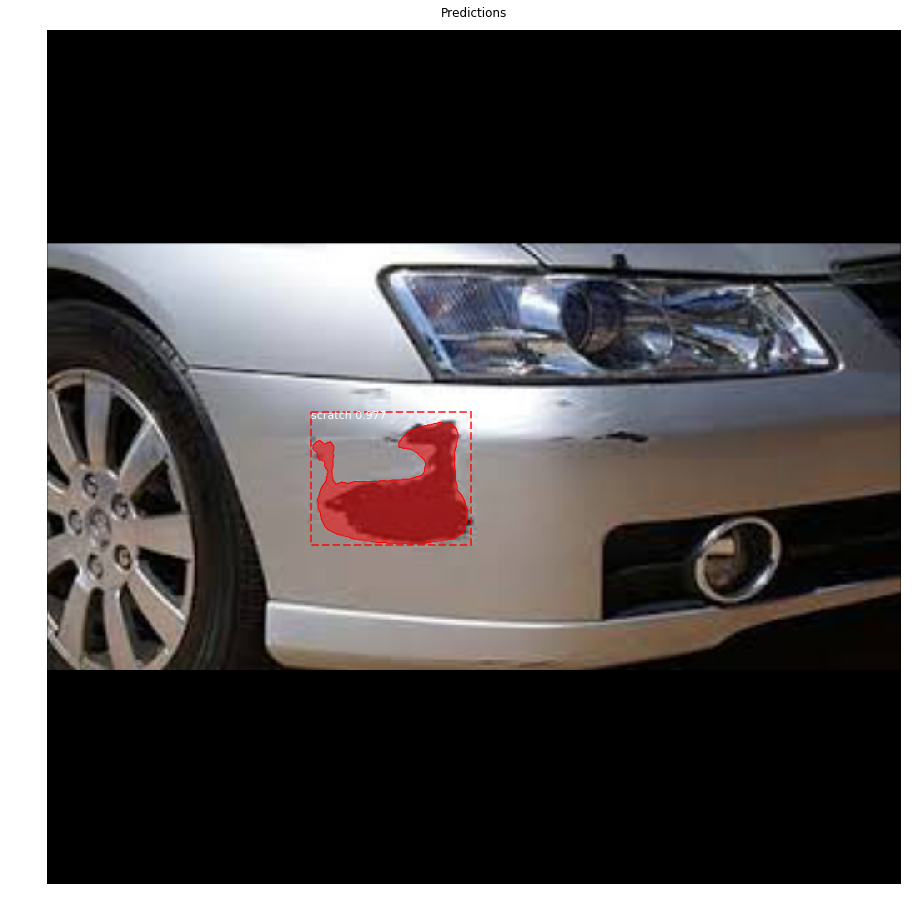

In [ ]:
image_id = random.choice(dataset.image_ids)
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset.image_reference(image_id)))

# Run object detection
results = model.detect([image], verbose=1)

# Display results
ax = get_ax(1)
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset.class_names, r['scores'], ax=ax,
                            title="Predictions")
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)
print('The car has:{} damages'.format(len(dataset.image_info[image_id]['polygons'])))

On another image

image ID: scratch.image52.jpeg (1) C:/Users/Sourish/Mask_RCNN/custom/val\image52.jpeg
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  141.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
gt_class_id              shape: (1,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (1, 4)                min:  272.00000  max:  930.00000  int32
gt_mask                  shape: (1024, 1024, 1)       min:    0.00000  max:    1.00000  bool
The car has:1 damages


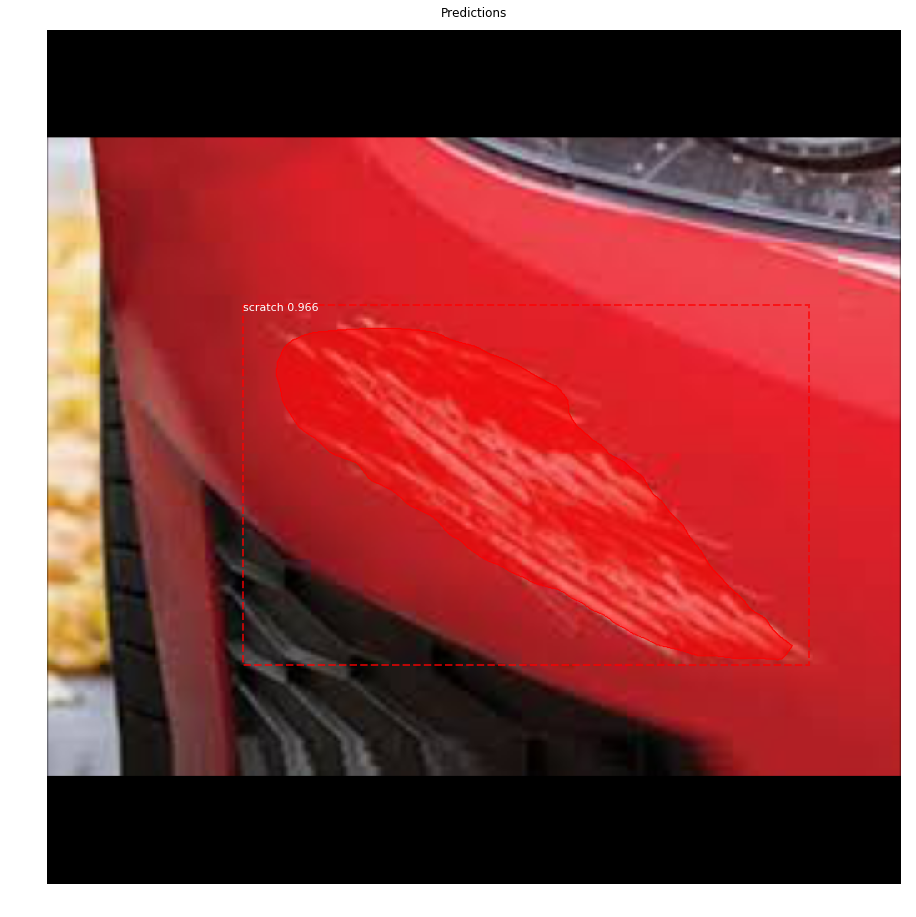

In [ ]:
image_id = random.choice(dataset.image_ids)
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset.image_reference(image_id)))

# Run object detection
results = model.detect([image], verbose=1)

# Display results
ax = get_ax(1)
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset.class_names, r['scores'], ax=ax,
                            title="Predictions")
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)
print('The car has:{} damages'.format(len(dataset.image_info[image_id]['polygons'])))

Pretty decent prediction considering training with only 49 images and 15 epochs.